### Titanic: Kaggle Competition

On this notebook we are going to classify whether a person survives or not in the Titanic accident based on different characteristics we have.

In order to achieve this we are going to implement some *Feature Engineering* techniques. This techniques will allow us to handle missing data, and transform data so that we end up with an optimal dataset for our ML task. We are going to implement four major aspects in order to achieve a good performance.

### Dataset

The data is gotten from [Kaggle](https://www.kaggle.com/c/titanic/data?select=train.csv): 

|Variable	|Definition	| Key|
|-----------|-----------|----|
|survival 	|Survival 	    |0 = No, 1 = Yes|
|pclass 	|Ticket class 	|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex 	    |Sex 	        ||
|Age 	    |Age in years 	||
|sibsp 	    |# of siblings / spouses aboard the Titanic||	
|parch 	    |# of parents / children aboard the Titanic||	
|ticket 	|Ticket number 	||
|fare 	    |Passenger fare ||	
|cabin 	    |Cabin number 	||
|embarked 	|Port of Embarkation| 	C = Cherbourg, Q = Queenstown, S = Southampton|


In [1]:
import pandas as pd
import seaborn as sns

In [2]:
file = "train.csv"
data = pd.read_csv(file)
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

We do not need neither the PassengerId nor the Name for training. Those attributes are just identifiers. They do not add relevant information

In [3]:
data.drop(columns=["PassengerId", "Name"], inplace=True)

### Data Exploratory Analysis

Is our first step of Feature Engineering. It involves the data understanding. We must be able to identify patterns and characteristics in our dataset.

In [4]:
# Data type of our columns
data.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [5]:
# Missing data by columns

print("Missing data", end="\n--------\n")
print(data.isnull().sum())

print(f"\nLenght of the data : {len(data)}")

Missing data
--------
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Lenght of the data : 891


We will need to find a way to fill the missing values on Age, Cabin and Embarked. We will tackle this issue later.

In [6]:
# List of categorical columns
cat = ["Sex","Ticket", "Cabin", "Embarked"]

#Some statistics
print("Mean\n--------", data.drop(columns=cat).mean(), sep="\n", end="\ns\n")
print("Median\n--------", data.drop(columns=cat).median(), sep="\n")

Mean
--------
Survived     0.383838
Pclass       2.308642
Age         29.699118
SibSp        0.523008
Parch        0.381594
Fare        32.204208
dtype: float64
s
Median
--------
Survived     0.0000
Pclass       3.0000
Age         28.0000
SibSp        0.0000
Parch        0.0000
Fare        14.4542
dtype: float64


As we can see: 
* The variance and the means are quite different. Altough linear models like linear regressions can handle this diversity. Other models like KNN may not. It may be interesting to scale the data in order to make them have a mean of 0 and a standard deviation of 1. 

* The predominant class is *not survived* with a frequency of 1-0.3838=0.6162; if we made a dummy classifier which always predict *not survived* we would get an accuracy around 0.60. Therefore, 0.6 of accuaraccy is our lower bound. Any classifier which achieves less accuracy is useless.

In [7]:
data.mode()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0.0,3.0,male,24.0,0.0,0.0,1601,8.05,B96 B98,S
1,NaN,NaN,NaN,NaN,NaN,NaN,347082,NaN,C23 C25 C27,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,CA. 2343,NaN,G6,NaN


On exploratory analysis is quite relevant the use of plots. Thanks to plots we can see how the features are distributed independently. Furthermore, we can see relations among features.


The library seaborn is quite useful. It is an extension of matplotlib specialize in data analysis

In [8]:
import seaborn as sns

Seaborn has four main kinds of plots: Ralational, Distributional, Categorical and Regressional.

The categorical api of seaborn provides us the function [catplot](https://seaborn.pydata.org/generated/seaborn.catplot.html) which allows us to analyze relationships among numerical and categorical data using different plots.

From [Seaborn Documentation](https://seaborn.pydata.org/generated/seaborn.catplot.html)  we can see that with catplot we can use any of the following functions by changing the parameter ``kind``

* Categorical scatterplots:
    * stripplot() (with kind="strip"; the default)
    * swarmplot() (with kind="swarm")

* Categorical distribution plots:
    * boxplot() (with kind="box")
    * violinplot() (with kind="violin")
    * boxenplot() (with kind="boxen")

* Categorical estimate plots:
    * pointplot() (with kind="point")
    * barplot() (with kind="bar")
    * countplot() (with kind="count")

Let's use some of them

I am not quite sure whether the feature Cabin will be useful. Lets see it.

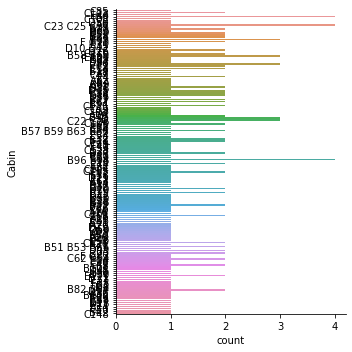

In [9]:
sns.catplot(data=data, y="Cabin", kind="count")

The cabin attribute is a lot diverse. It seems to be also an identifier. In addition, it is the feature that has the less data samples. We have 687 of 891 null values. However, if we only keep the zone (instead of b57 have only b) it would make a lot of sense. People who is in a zone far away from the colision may survive. Thus, I will make some tests before removing this feature.

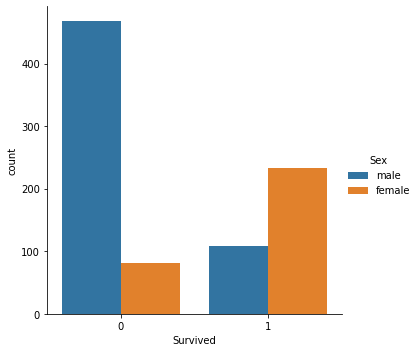

In [10]:
sns.catplot(data=data, x="Survived", hue="Sex", kind="count")

From this plot we can see that being female increases your probability of being saved. This makes sense since the policy of evacuation gave priority to women and children. We should also see something similar with age.

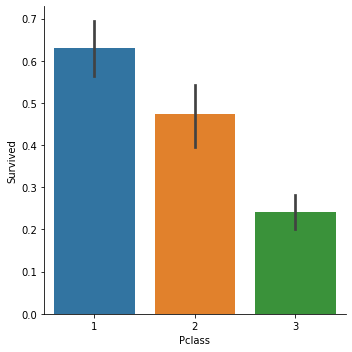

In [11]:
sns.catplot(data=data, y="Survived", x="Pclass", kind="bar")

It seems that the pclass is also related with surviving. Altough it is not quite clear that the proportion of people belonging to class 1 or 2 that survives is grater than 0.5, we can ensure that the proportion of people belonging to class 3 who survies is far less than 0.5.

Lets see how the pclass and  sex relates to survived

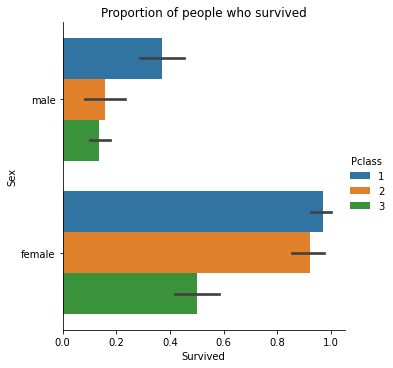

In [12]:
sns.catplot(data=data, x="Survived", y="Sex", hue="Pclass", kind="bar").set(title="Proportion of people who survived")

This result is quite curious and kind of expected. The proportion of women of third class who survived is greater than the proportion of men of first class who survived.

If we made a classifier that predicts survive if the sex is female and not survive else, which accuracy would  we get?

In [13]:
prediction = data.Sex.apply(lambda x: x=="female")
(prediction == data.Survived).apply("mean")

0.7867564534231201

*And our accuracy in train is around 75 and 80 percent. Now, in order to build a better classifier we need to outperform this one.*

Let's explore more things: The ticket numbers for example

In [14]:
data.Ticket.unique().shape

(681,)

The tickets are quite spread. They are just identifiers. I personally do not think that could apport any value. Therefore we remove.

In [15]:
data.drop("Ticket", axis=1, inplace=True)

Now the Embarked place

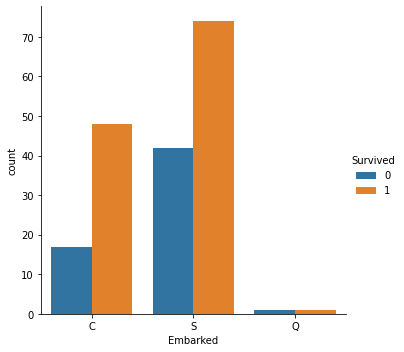

In [16]:
sns.catplot(data=data.dropna(), hue="Survived", x="Embarked", kind="count")

What about the proportions?

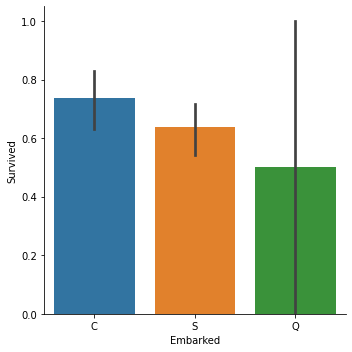

In [17]:
sns.catplot(data=data.dropna(), y="Survived", x="Embarked", kind="bar")

I would say that it gives not much information about survived. But we would confirm or not on the feature selection part.

Altough we number of siblings and parents can be analyzed through these categorical plots. We are goint to use other kind of plots just to explore the capabilities of seaborn.


The distributional api of Seaborn provides us the function [distplot](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn.displot) which in a simmilar way that catplot, allows us to plot a sort of diferent distributional plots.

From seaborn [documentation](https://seaborn.pydata.org/api.html#distribution-api):

* **Univariate or bivariate:**
    * hist() (hist)
    * kdeplot() (kde)

* **Univariate:**
   * ecdfplot(ecdf)


 **Note:** Additionally, a rugplot() can be added to any kind of plot to show individual observations.
	

Let's analyze Age

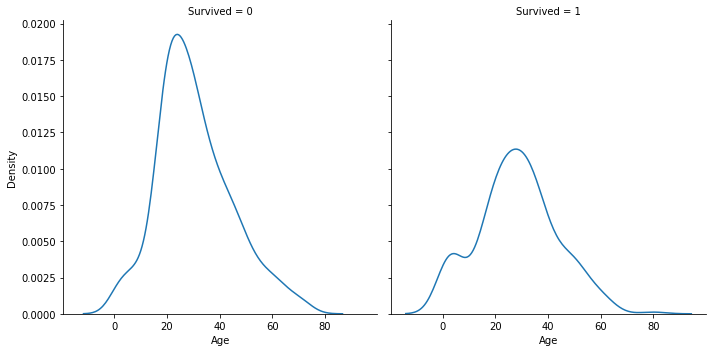

In [26]:
sns.displot(data=data, x="Age",  col="Survived", kind="kde")

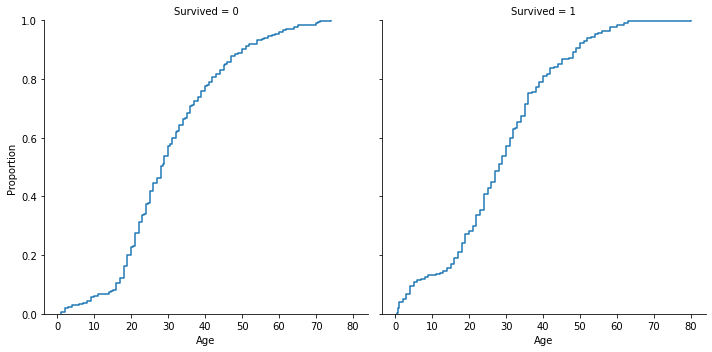

In [27]:
sns.displot(data=data, x="Age", col="Survived", kind="ecdf")

These two plots lets us see that the proportion of children who survived is sligthly bigger in the distribution of people who survived

Now let's see the number of siblings

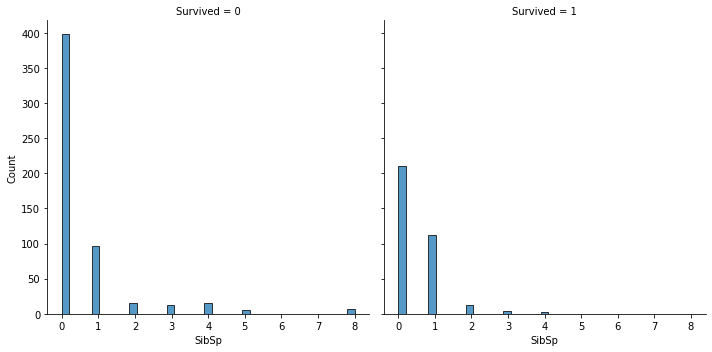

In [32]:
sns.displot(data=data, x="SibSp", col="Survived", kind="hist")

I can not conclude something about this plot. We will have to analyze it with feature selection.

Finally lets see what is going on with the number of parents present.

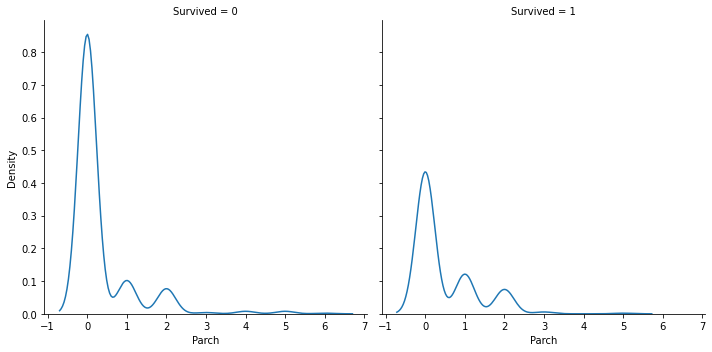

In [35]:
sns.displot(data=data, x="Parch", col="Survived", kind="kde")

It seems that having one or more parents gives children more oportunities to survive.

The relational api of Seaborn provides us the function [relplot](https://seaborn.pydata.org/generated/seaborn.relplot.html#seaborn.relplot) which in a simmilar way that catplot, allows us to plot a sort of diferent relational plots.

From seaborn [documentation](https://seaborn.pydata.org/api.html#distribution-api):

* scatterplot() (scatter)
* lineplot() (line)

Sadly, this daset does not have many numerical data. Thus we can not use that much this plots.

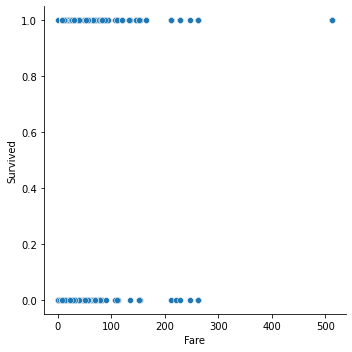

In [43]:
sns.relplot(data=data, x="Fare", y="Survived", kind="scatter")

The regresional api of Seaborn provides us a set of functions:

From seaborn [documentation](https://seaborn.pydata.org/api.html#distribution-api):

* [lmplot()](https://seaborn.pydata.org/generated/seaborn.lmplot.html#seaborn.lmplot) This function combines regplot() and FacetGrid. It is intended as a convenient interface to fit regression models across conditional subsets of a dataset.
* [regplot()](https://seaborn.pydata.org/generated/seaborn.regplot.html#seaborn.regplot) Plot data and a linear regression model fit.
* [residplot()](https://seaborn.pydata.org/generated/seaborn.residplot.html#seaborn.residplot) This function will regress y on x (possibly as a robust or polynomial regression) and then draw a scatterplot of the residuals. You can optionally fit a lowess smoother to the residual plot, which can help in determining if there is structure to the residuals.

We are going to try some regressions

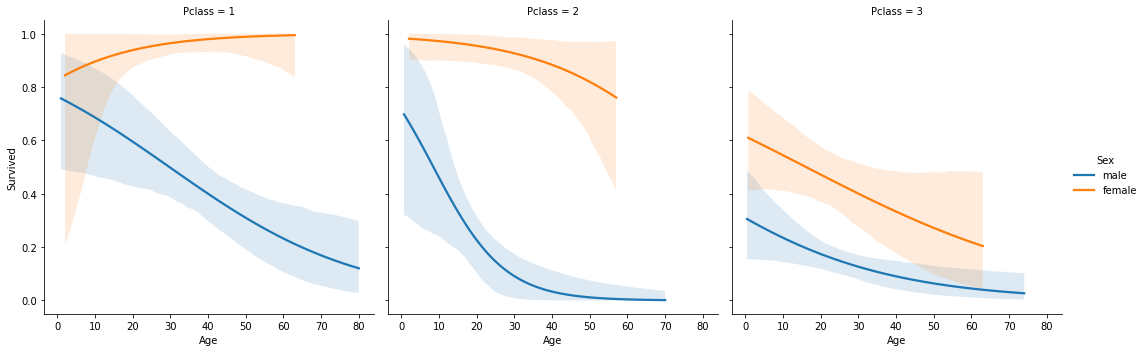

In [64]:
sns.lmplot(data=data, x="Age", col="Pclass", hue="Sex", y="Survived", logistic=True)

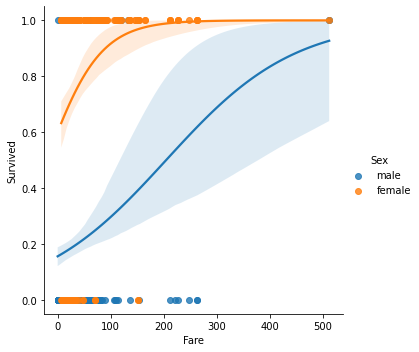

In [73]:
sns.lmplot(data=data, x="Fare", hue="Sex", y="Survived", logistic=True)

Seems that the Fare can help us to determine if a passanger survived. Lets check how is it related with age.

<AxesSubplot:xlabel='Fare', ylabel='Age'>

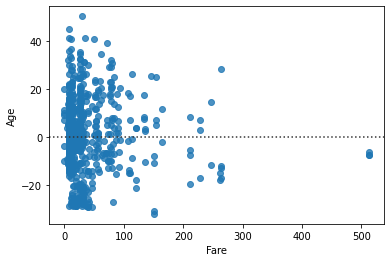

In [75]:
sns.residplot(data=data, x="Fare", y="Age")

There is not a clear relation. We may be able to use both.